## Predictive Customer Analysis 

Following the descriptive analysis of the customer purchase on `Positioning_descriptive.ipynb` notebook, here logistic regression and linear regression will be applied will be performed to deepdive into purchase analysis and forecast.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder

from sklearn.linear_model import LogisticRegression

import os 
import pickle

## Import the Data

In [2]:
def import_pickle_data(filename) :
    path = os.path.join(os.getcwd(), 'obj_data', filename)
    return pickle.load(open(path, 'rb')) #rb = read as byte datatype

In [3]:
def import_csv(filePath) :
    return pd.read_csv(filePath)

In [4]:
# loading the data file
filePath_purchase = os.path.join(os.getcwd(), 'data', 'purchase data.csv')
df_purchase = import_csv(filePath_purchase)

# importing classes
scaler = import_pickle_data('scaler.pickle')
pca = import_pickle_data('pca.pickle')
kmeans_pca = import_pickle_data('kmeans_pca.pickle')

# standardization
df_purchase.columns.values[-7:] # the 7 features standized 
features_to_include = df_purchase.columns.values[-7:]
df_purchase_std = scaler.transform(df_purchase[features_to_include])

# dimentionality reduction of the standardized data
df_purchase_pca = pca.transform(df_purchase_std)

# segmentation from the preprocessed data
segment_kmeans_pca = kmeans_pca.predict(df_purchase_pca)
df_purchase_analysis = df_purchase.copy()
df_purchase_analysis['Segment'] = segment_kmeans_pca

# binary encoding segment
segment_dummies = pd.get_dummies(df_purchase_analysis['Segment'], 
                                 prefix='Segment', prefix_sep='_')
df_purchase_analysis = pd.concat([df_purchase_analysis, segment_dummies], axis=1)

In [5]:
# Differentiate the dataframe for convenience
df_pa = df_purchase_analysis.copy()

---
## `1.` Purchase probability model

Using logistic regression : 
- Target variable (Y) : Incidence (purchased - 0: no, 1: yes)
- Independent variable (X) : Price, using mean / ~~median~~ in this case

In [6]:
Y = df_pa['Incidence']

In [7]:
brand_prices = df_pa.loc[:, df_pa.columns.str.contains('Price_')]
X = pd.DataFrame({'Mean_price' : brand_prices.mean(axis=1)})

In [8]:
logit_purchase = LogisticRegression(solver='sag')

In [9]:
logit_purchase.fit(X, Y)

LogisticRegression(solver='sag')

In [10]:
logit_purchase.coef_

array([[-2.34771307]])

---
### Price elasticity of purchase probability

**Quick overview of elasticity**

Price elasticity of purchase probability : % change in purchase probability in response to a 1% change in price

- Rearranged formula :

$$ E = beta * price * (1-Pr(purchase) $$

- Interpretation : 

$$ |E| < 1 : inelastic, or : elastic $$

### Forecast price elasticity in response to price change

In [11]:
brand_prices.describe() # prices ranged bewteen 1.1 to 2.8

,Price_1,Price_2,Price_3,Price_4,Price_5
count,58693.000000,58693.000000,58693.000000,58693.000000,58693.000000
mean,1.392074,1.780999,2.006789,2.159945,2.654798
std,0.091139,0.170868,0.046867,0.089825,0.098272
min,1.100000,1.260000,1.870000,1.760000,2.110000
25%,1.340000,1.580000,1.970000,2.120000,2.630000
50%,1.390000,1.880000,2.010000,2.170000,2.670000
75%,1.470000,1.890000,2.060000,2.240000,2.700000
max,1.590000,1.900000,2.140000,2.260000,2.800000


In [12]:
# Create a new range of price to predict PE (price elasticity)
price_range = np.arange(0.5, 3.5, 0.01)

# sklearn requires 2D array of X to predict y
df_price_range = pd.DataFrame(price_range)

In [13]:
# purchase probability matrix
purchase_pr_mat = logit_purchase.predict_proba(df_price_range)
purchase_pr = purchase_pr_mat[:,1]

In [14]:
# calculating price elatisticity for purchase probability
PE = logit_purchase.coef_[0] * price_range * (1 - purchase_pr)

In [15]:
df_price_elast = pd.DataFrame({'Price_point' : price_range, 
                               'Elasticity' : PE})

In [16]:
elastic_breakpoint = np.argmax(df_price_elast['Elasticity'] <= -1.0) # index = 75
df_price_elast.iloc[72:78,:] # below 75 : inelastic

,Price_point,Elasticity
72,1.22,-0.935287
73,1.23,-0.957922
74,1.24,-0.980921
75,1.25,-1.004283
76,1.26,-1.028007
77,1.27,-1.052095


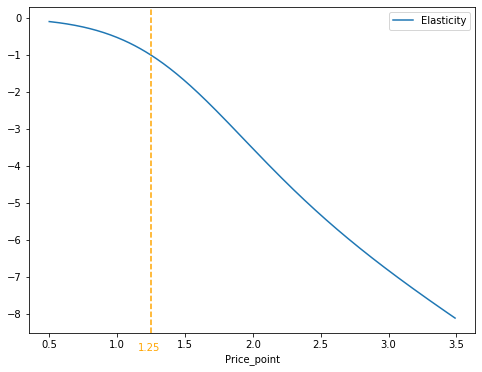

In [17]:
df_price_elast.plot(x='Price_point', y='Elasticity', figsize=(8,6))

price_breakpoint = df_price_elast.loc[elastic_breakpoint, 'Price_point']
plt.axvline(x= price_breakpoint, 
            color='orange', ls='--')
plt.text(x=price_breakpoint-0.1, y=-9, s='{0:.2f}'.format(price_breakpoint), color='orange')
plt.show()

Up to price point of 1.25, the purchase probability is inelastic in respone to price. The curve gets stepper above the price level, suggesting the increase in price will cause a greater impact (negatively) on purchase.

---
## `2.` Purchase probability by segment

Earlier in the descriptive analysis, each segment shows different preference for brand i.e. Fewer Opportunity favoring the relatively lower-priced Brand 2, as opposed to Career Focused & Well off segments going for more premium Brands. 

Let's see if logistic regression model can also tell this tendency by observing price elasticity.

segment_index = {
    0 : 'Fewer Opportunity',
    1 : 'Career Focused',
    2 : 'Standard',
    3 : 'Well off'
}

In [18]:
# data is more abundant for Fewer Opporunity segment 
# which 'may' help the data to better fit 
df_pa.Segment.value_counts() 

0    21526
1    13677
2    12123
3    11367
Name: Segment, dtype: int64

### `2-1.` Fewer Opportunity

The below code tested fine!

In [19]:
# df_pa_seg0 = df_pa.query('Segment == 0')
# Y_seg0 = df_pa_seg0['Incidence']
# brand_prices_seg0 = df_pa_seg0.loc[:, df_pa_seg0.columns.str.contains('Price_')]
# X_seg0 = pd.DataFrame({'Mean_price' : brand_prices_seg0.mean(axis=1)})

# logit_seg0 = LogisticRegression(solver='sag')
# logit_seg0.fit(X_seg0, Y_seg0)
# beta_seg0 = logit_seg0.coef_ # the degree is larger than total : array([[-2.34834598]])
# beta_seg0

# # using the price range earlier defined
# purchase_pr_seg0 = logit_seg0.predict_proba(df_price_range)[:,1] 

# PE_seg0 = beta_seg0 * price_range * (1-purchase_pr_seg0)

# df_price_elast.insert(2, column='PE_Segment_0', value=PE_seg0[0])

# df_price_elast.plot(x='Price_point', y=['Elasticity','PE_Segment_0'])
# plt.show()

Construct a function to create a consolidated **`df_price_elast`** dataframe

In [20]:
def construct_elast_by_segment(list_segment_index) :
    # will return a consolidated dataframe
    for idx in list_segment_index :
        
        # SET UP : EXTRACT VARIABLES           
        df_seg = df_pa.query(f'Segment == {idx}') #df_pa: a copy of imported df_purchase_analysis
        Y = df_seg['Incidence']
        brand_prices = df_seg.loc[:, df_seg.columns.str.contains('Price_')]
        X = pd.DataFrame(brand_prices.mean(axis=1))
        
        # FITTING LOGISTIC REGRESSION MODEL
        logit = LogisticRegression(solver='sag')
        logit.fit(X, Y)
        beta = logit.coef_
        
        # FORECASTING WITH NEW PRICE RANGE
        price_range = np.arange(0.5, 3.5, 0.01)    
        df_price_range = pd.DataFrame(price_range)        
        purchase_prob = logit.predict_proba(df_price_range)[:, 1]
        PE = beta * price_range * (1-purchase_prob)
        
        # CONSTRUCT A NEW DATAFRAME ADDED TO df_price_elast
        df_price_elast.insert(idx+2, column= f'PE_Segment_{idx}', value=PE[0])
        
    return df_price_elast

In [21]:
list_segment_index = list(set(df_pa.Segment))
df_price_elast_seg = construct_elast_by_segment(list_segment_index)

In [22]:
# pd.set_option('display.max_rows', None)
# df_price_elast_seg

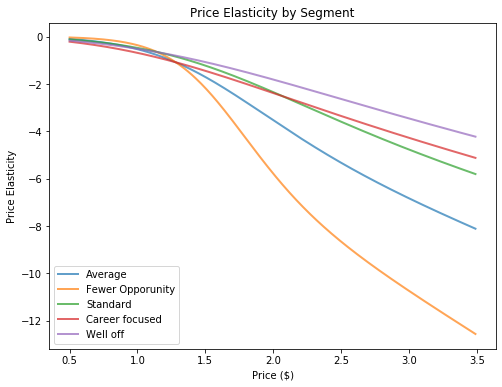

In [23]:
y_cols = df_price_elast_seg.columns.values[1:]
y_labels = ['Average', 'Fewer Opporunity', 'Standard', 'Career focused', 'Well off']

plt.figure(figsize=(8,6))

for i in range(len(y_cols)) :
    plt.plot(df_price_elast_seg['Price_point'],
             df_price_elast_seg[y_cols[i]], 
             label=y_labels[i], linewidth=2, alpha=0.7)
    
plt.title('Price Elasticity by Segment', fontsize=12)
plt.xlabel('Price ($)')
plt.ylabel('Price Elasticity')
plt.legend(loc='lower left')
    
plt.show()

The plot for `Fewer Opportuntiy` segment starts to get steeper to the large extent at the price point of $ 1.38, above which price elasticity for the segment > 1. 

`Career focused` segment gets elastic at price point of $1.24, which is the lower price point than Fewer Opporunity. However, the overall steepness is not as great as Fewer Opporunity segment, which suggests the segment is less price sensitive in the purchase of the product as expected from the descriptive analysis. 

`Well off` segment shows the least elastic to price change, which is rather self-explanatory. 

Overall price elasticity got greater with Few Opportunity Segment, seeing the other three segments trend well above the averge line as price rises.

**_Annecdote_** : sample size differs across each segment, and the model accuracy is likely to vary.

---
## `3.` Purchase model with promotion
Evaluate price elasticity when there is promotion or not

In [26]:
Y = df_pa['Incidence']

In [39]:
X = pd.DataFrame( ( df_pa['Price_1'] +
                    df_pa['Price_2'] +
                    df_pa['Price_3'] +
                    df_pa['Price_4'] +
                    df_pa['Price_5'] ) / 5 ) 
X.rename(columns={0: 'Mean_price'}, inplace=True)

In [43]:
X['Mean_promo'] = ( df_pa['Promotion_1'] +
                    df_pa['Promotion_2'] +
                    df_pa['Promotion_3'] +
                    df_pa['Promotion_4'] +
                    df_pa['Promotion_5'] ) / 5 

In [48]:
X.head(3)

,Mean_price,Mean_promo
0,2.044,0.2
1,2.028,0.0
2,2.028,0.0


In [49]:
X.Mean_promo.value_counts()

0.2    24040
0.0    22748
0.4     9516
0.6     2389
Name: Mean_promo, dtype: int64

In [50]:
logit_promo = LogisticRegression(solver='sag')

In [51]:
logit_promo.fit(X, Y)

LogisticRegression(solver='sag')

In [52]:
logit_promo.coef_ 

array([[-1.49395553,  0.56148704]])

---
### Price elasticity with promotion

In [66]:
#price_range

In [55]:
df_price_range.rename(columns={0:'Price_range'},
                      inplace=True)

In [57]:
# When promotion = 1
df_price_range_promo = df_price_range.copy()
df_price_range_promo['Promotion'] = 1

In [60]:
purchase_prob_promo = logit_promo.predict_proba(df_price_range_promo)

In [68]:
PE_promo_1 = logit_promo.coef_[:,0] * price_range * ( 1- purchase_prob_promo[:,1])

In [70]:
PE_promo_1.shape

(300,)

---
### Price elasticity without promotion

In [73]:
# When promotion = 0
df_price_range_promo = df_price_range.copy()
df_price_range_promo['Promotion'] = 0
purchase_prob_promo = logit_promo.predict_proba(df_price_range_promo)
PE_promo_0 = logit_promo.coef_[:,0] * price_range * ( 1- purchase_prob_promo[:,1])
PE_promo_0.shape

(300,)

---
### Combining all the results 

In [75]:
df_price_elast_combined = df_price_elast_seg.copy()
df_price_elast_combined['PE_promo_1'] = PE_promo_1
df_price_elast_combined['PE_promo_0'] = PE_promo_0

In [82]:
df_price_elast_promo = df_price_elast_combined[['Price_point', 'PE_promo_1', 'PE_promo_0']]
df_price_elast_promo.head(3)

,Price_point,PE_promo_1,PE_promo_0
0,0.50,-0.125735,-0.195642
1,0.51,-0.129851,-0.201763
2,0.52,-0.134046,-0.207987


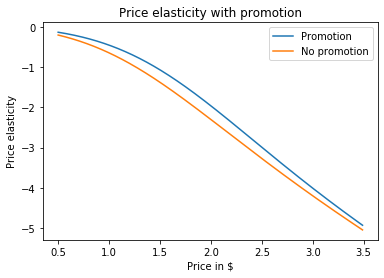

In [99]:
df_price_elast_promo.plot(x='Price_point', y=['PE_promo_1', 'PE_promo_0'], 
                          figsize=(6,4), label=['Promotion', 'No promotion'])

plt.title('Price elasticity with promotion')
plt.xlabel('Price in $')
plt.ylabel('Price elasticity')
plt.show()

In [95]:
#pd.set_option('display.max_rows', None)
df_price_elast_promo.loc[75:80], df_price_elast_promo.loc[95:100]

(    Price_point  PE_promo_1  PE_promo_0
 75         1.25   -0.715125   -0.973107
 76         1.26   -0.727502   -0.987908
 77         1.27   -0.740008   -1.002814
 78         1.28   -0.752643   -1.017826
 79         1.29   -0.765406   -1.032942
 80         1.30   -0.778296   -1.048162,
      Price_point  PE_promo_1  PE_promo_0
 95          1.45   -0.986821   -1.288142
 96          1.46   -1.001714   -1.304869
 97          1.47   -1.016728   -1.321680
 98          1.48   -1.031861   -1.338575
 99          1.49   -1.047114   -1.355551
 100         1.50   -1.062486   -1.372607)

**Annecdote** Promotion here includes not only price discount but marketing campaign, etc.

Across all price points, price elasticity is lower (less steeper) with promotion than without promotion. 

Inelasticity for no promotion ends at \\$1.27 as opposed to \\$1.46 with promotion. The difference may sound trivial but it actually is not especially when high volume of sales involved. For the same price change, customers react less sensitive when promtional activities are implemented.

---
#### Brand choice analysis will be conducted in a seperate notebook `Positioning_predictive_2`